<a href="https://colab.research.google.com/github/kevinbrnett/sales-predictions/blob/main/Sales_Predictions_Part_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 Revisited
- Kevin Barnett
- 06/14/2023


## Data Dictionary


- Item_Identifier: Unique product ID
- Item_Weight: Weight of product
- Item_Fat_Content: Whether the product is low fat or regular
- Item_Visibility: The percentage of total display area of all products in a store allocated to the particular product
- Item_Type: The category to which the product belongs
- Item_MRP: Maximum Retail Price (list price) of the product
- Outlet_Identifier: Unique store ID
- Outlet_Establishment_Year: The year in which store was established
- Outlet_Size: The size of the store in terms of ground area covered
- Outlet_Location_Type: The type of area in which the store is located
- Outlet_Type: Whether the outlet is a grocery store or some sort of supermarket
- Item_Outlet_Sales: Sales of the product in the particular store. This is the target variable to be predicted.

## Import Libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
import joblib
import statsmodels.api as sm

# Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

## Functions

In [2]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    # Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

In [3]:
def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

In [4]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False):
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
        
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
        
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [5]:
def annotate_hbars(ax, ha='left', va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha, va=va, size=size,
                        xytext=xytext, textcoords=textcoords)

## Loading Data


In [6]:
# Create dataframe and see if data loaded correctly
filename = '\\Users\\hamma\\Documents\\GitHub\\Project-1-Linear-Regression-Project\\sales_predictions.csv'
df = pd.read_csv(filename)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

## Question 1: How many rows and columns are there?
- There are 12 columns and 8523 rows

## Question 2: What are the datatypes of each variable?
- 'Item_Identifier' = 'object'
- 'Item_Weight' = 'float64'
- 'Item_Fat_Content' = 'object'
- 'Item_Visibility = 'float64'
- 'Item_Type = 'object'
- 'Item_MRP' = 'float64'
- 'Outlet_Identifier' = 'object'
- 'Outlet_Establishment_Year' = 'int64'
- 'Outlet_Size' = 'object'
- 'Outlet_Location_Type' = 'object'
- 'Outlet_Type' = 'object'
- 'Item_Oulet_Sales' = 'float64'

## Data Cleaning


In [7]:
# Check for any duplicates
df.duplicated().any()

False

> There are no duplicate values

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [9]:
# Identify any missing values
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

- There are 1463 missing rows of data in the 'Item_Weight' column
- There are 2410 missing rows of data in the 'Outlet_Size' column

In [10]:
print(df['Item_Weight'].isna().value_counts(normalize=True),'\n')
df['Outlet_Size'].isna().value_counts(normalize=True)

False    0.828347
True     0.171653
Name: Item_Weight, dtype: float64 



False    0.717236
True     0.282764
Name: Outlet_Size, dtype: float64

> In the 'Item_Weight" column, 17% of values are missing. In the 'Outlet_Size' column, 28% of the values are missing

In [11]:
# Impute the mean of item weights for missing data
df['Item_Weight'].fillna( value = df['Item_Weight'].mean(), inplace = True)
df.isna().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

> To resolve missing data in the 'Item_Weight' column the mean of the column was put in place for the missing values. This was done since there was no way to actually know what the item weights

In [12]:
# Check number of unique values for the Outlet_Size column
df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [13]:
# Impute 'Medium' for missing data
df['Outlet_Size'].fillna(value = 'Medium', inplace = True)
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

> To resolve the missing data in the 'Outlet_Size' column 'Medium' was put in place for the missing data. This was done since 'Medium' was over 50% of the data in the column

In [14]:
# Delete Unnecessary Columns
df.drop(columns=['Item_Identifier','Outlet_Identifier'],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                8523 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Establishment_Year  8523 non-null   int64  
 6   Outlet_Size                8523 non-null   object 
 7   Outlet_Location_Type       8523 non-null   object 
 8   Outlet_Type                8523 non-null   object 
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 666.0+ KB


> The 'Item_Identifier' and 'Outler_Identifier' columns were deleted since they were unique values.

In [15]:
# Check columns for inconsistencies in data values in the 'Item_Fat_Content' column
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [16]:
# Replace 'LF', 'low fat' with 'Low Fat' and 'reg' with 'Regular' 
df.replace({'LF': 'Low Fat','reg': 'Regular','low fat': 'Low Fat'}, inplace = True)
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [17]:
# Check columns for inconsistencies in data values in the 'Item_Type' column
df['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [18]:
# Check columns for inconsistencies in data values in the 'Outlet_Size' column
df['Outlet_Size'].value_counts()

Medium    5203
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [19]:
# Change 'High' value to 'Large' as it makes more sense in this case
df.replace({'High':'Large'}, inplace=True)
df['Outlet_Size'].value_counts()

Medium    5203
Small     2388
Large      932
Name: Outlet_Size, dtype: int64

In [20]:
# Check columns for inconsistencies in data values in the 'Outlet_Establishment_Year' column
df['Outlet_Establishment_Year'].value_counts()

1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64

> The only column that had inconsistencies was the 'Item_Fat_Content' column. The data values were replaced to make the data consistent

In [21]:
# Display summary of the statistics and check for impossible values
df.describe()

Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count  8523.000000      8523.000000  8523.000000                8523.000000   
mean     12.857645         0.066132   140.992782                1997.831867   
std       4.226124         0.051598    62.275067                   8.371760   
min       4.555000         0.000000    31.290000                1985.000000   
25%       9.310000         0.026989    93.826500                1987.000000   
50%      12.857645         0.053931   143.012800                1999.000000   
75%      16.000000         0.094585   185.643700                2004.000000   
max      21.350000         0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          3101.296400  
max         13086.964800

## Exploratory Visuals


In [22]:
# Show the information for the data frame again
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                8523 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Establishment_Year  8523 non-null   int64  
 6   Outlet_Size                8523 non-null   object 
 7   Outlet_Location_Type       8523 non-null   object 
 8   Outlet_Type                8523 non-null   object 
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 666.0+ KB


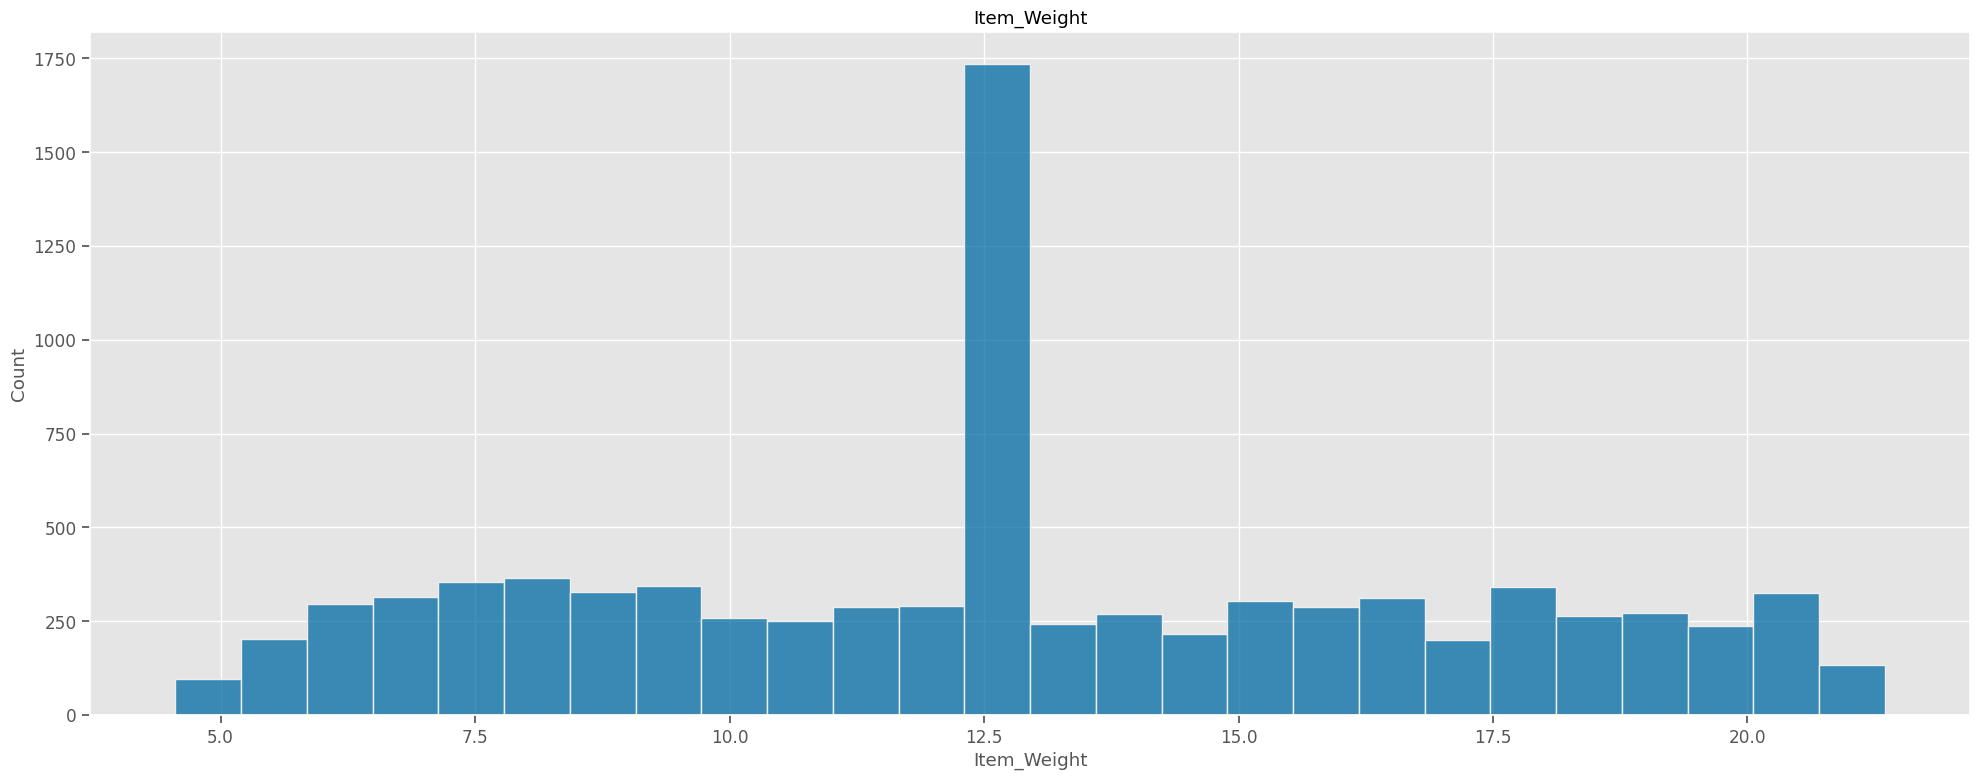

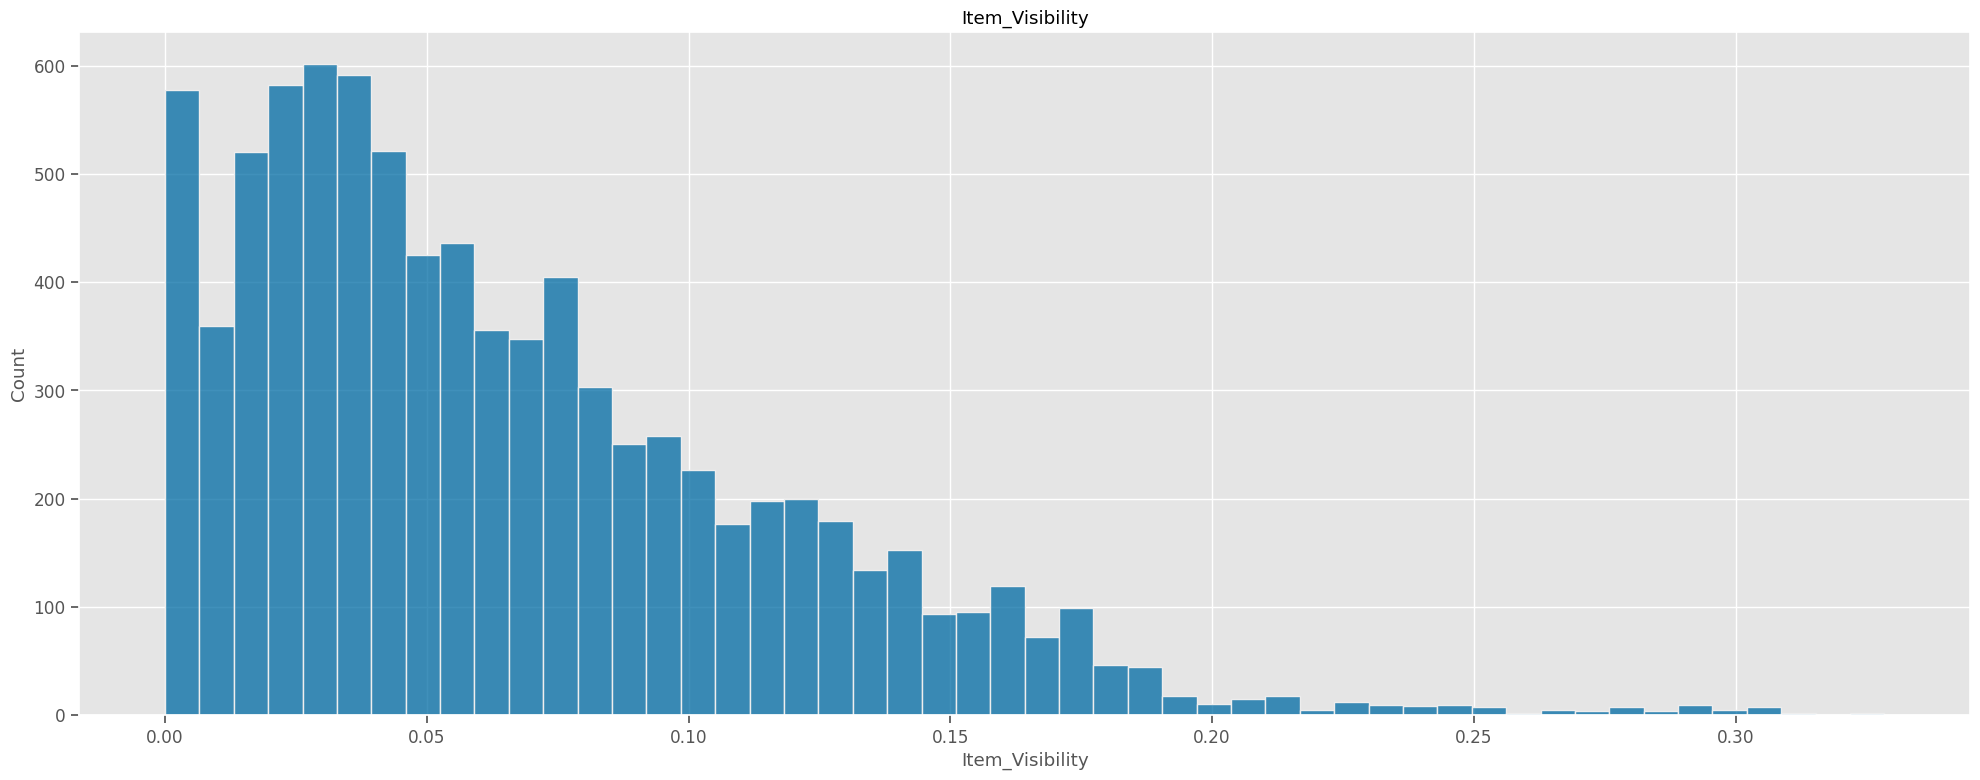

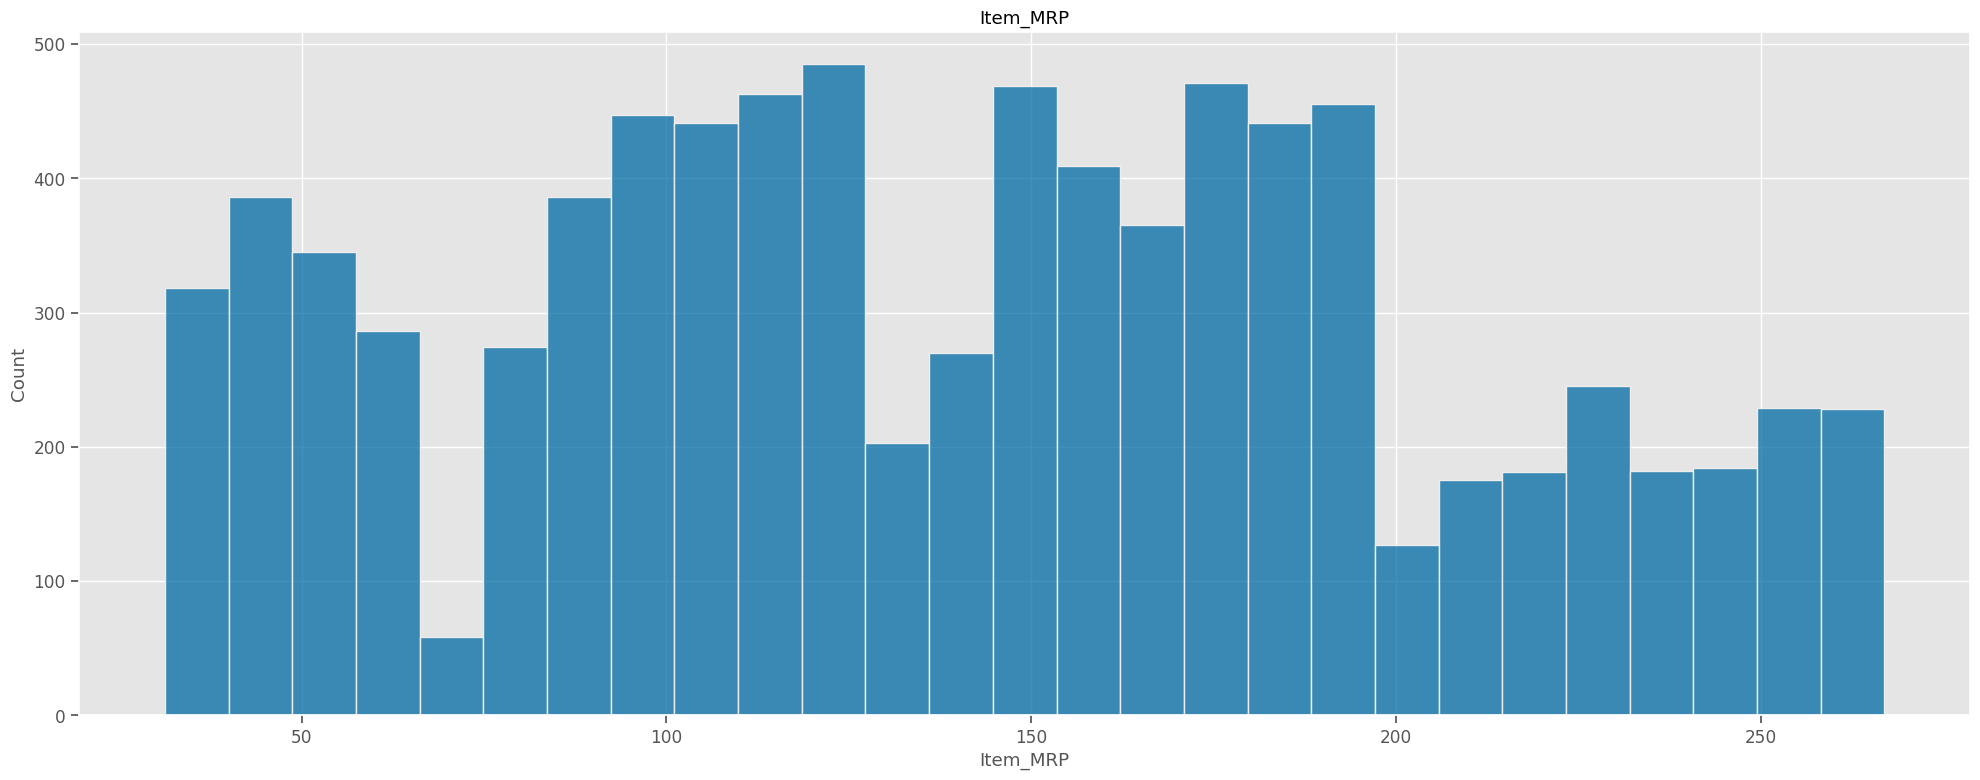

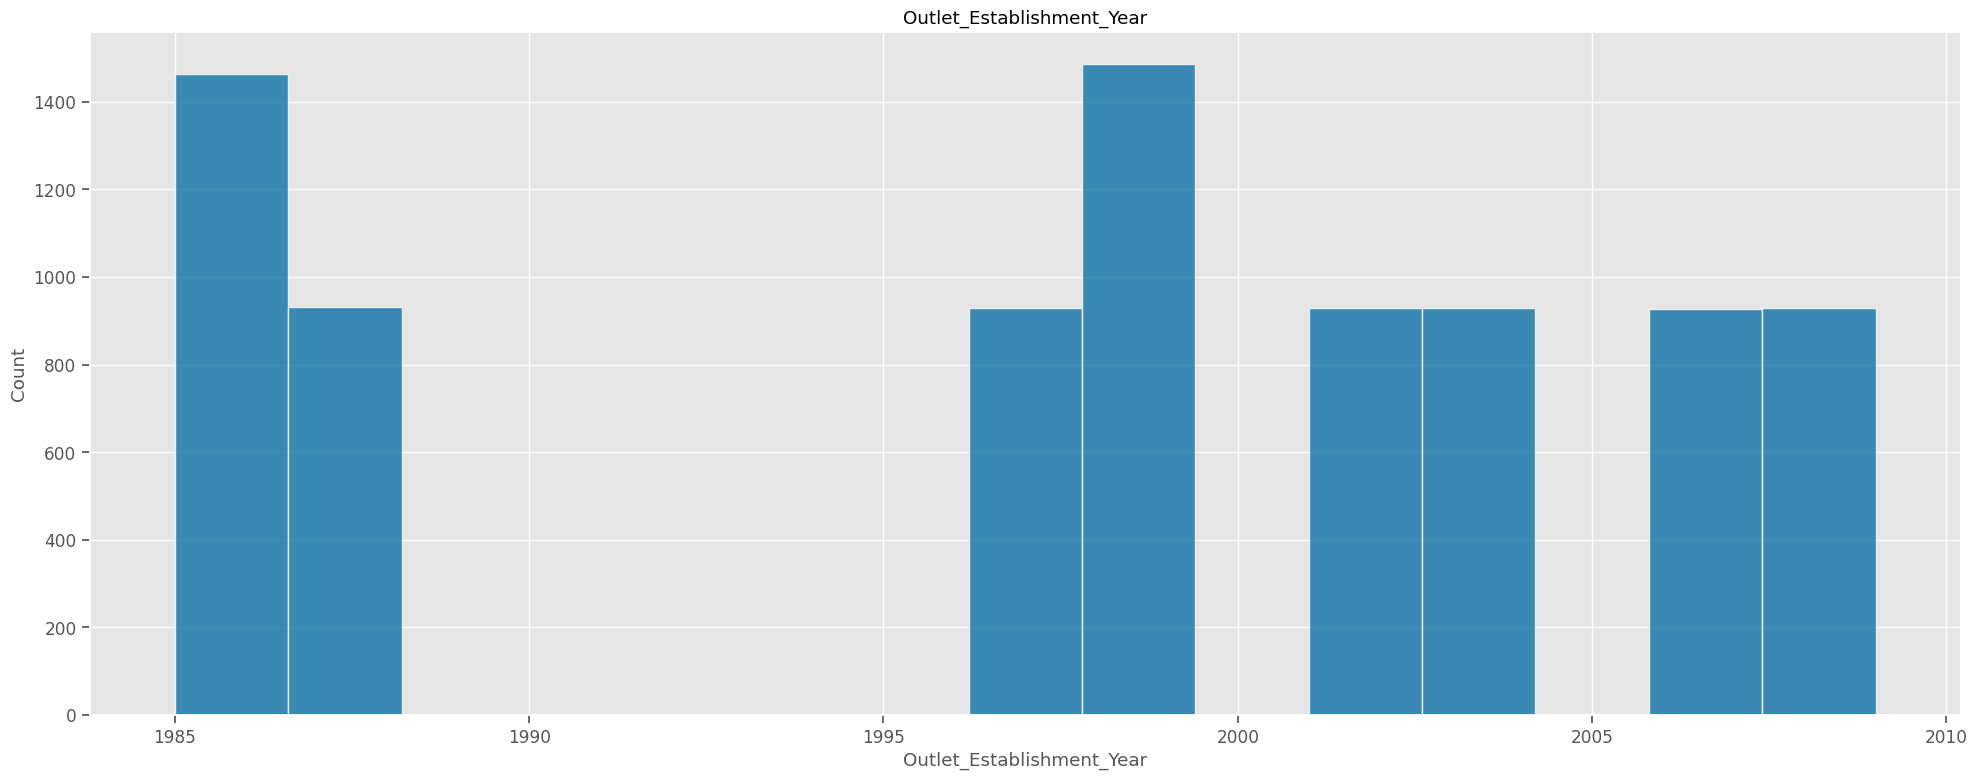

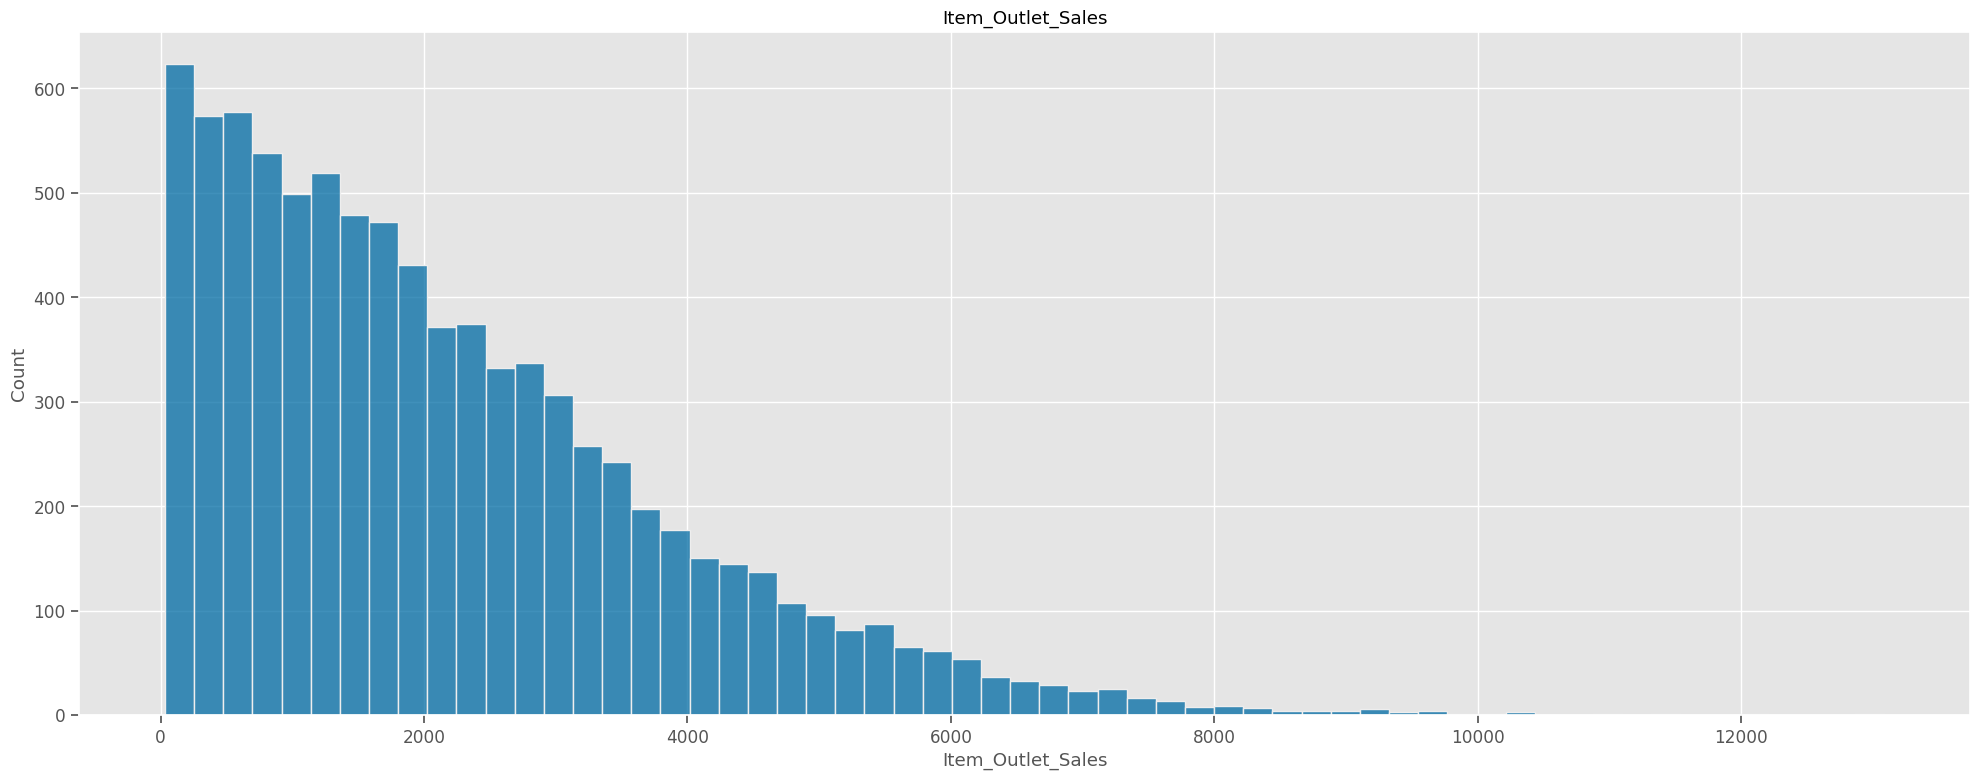

In [23]:
# Create for loop to create histograms for numeric features
# Create variable to select numeric columns
num_columns = df.select_dtypes('number')

for column in num_columns:
  plt.figure(figsize = (20, 8))
  plt.title(column)
  sns.histplot(x = df[column])

  # Display visualizations
  plt.tight_layout()
  plt.show()

> We can see that the data for item sales and visibility are both skewed to the right. Both of these features also have a significant amount of outliers. With the item MRP, item weight, and establishment year features there does not seem to be a pattern in the histogram.

In [24]:
# Create custom function to create EDA with barplots for categorical frequencies
# EDA to plot barplots
def bar_plot(data, x, y, size = (12, 8)):
  fig, ax = plt.subplots(figsize = size)
  # Count up categories and sort values
  count = df[x].value_counts().sort_values(ascending= False).to_frame()

  # Create barplot
  sns.barplot(data = count, x = count.index, y = count[x], ax = ax)
  plt.xticks(rotation = 75)
  ax.set_title(f'Categorical Frequencies of {y}')
  ax.set_xlabel(f'Categories for {y}')
  ax.set_ylabel(f'Counts')
  plt.tight_layout()

  return fig, ax

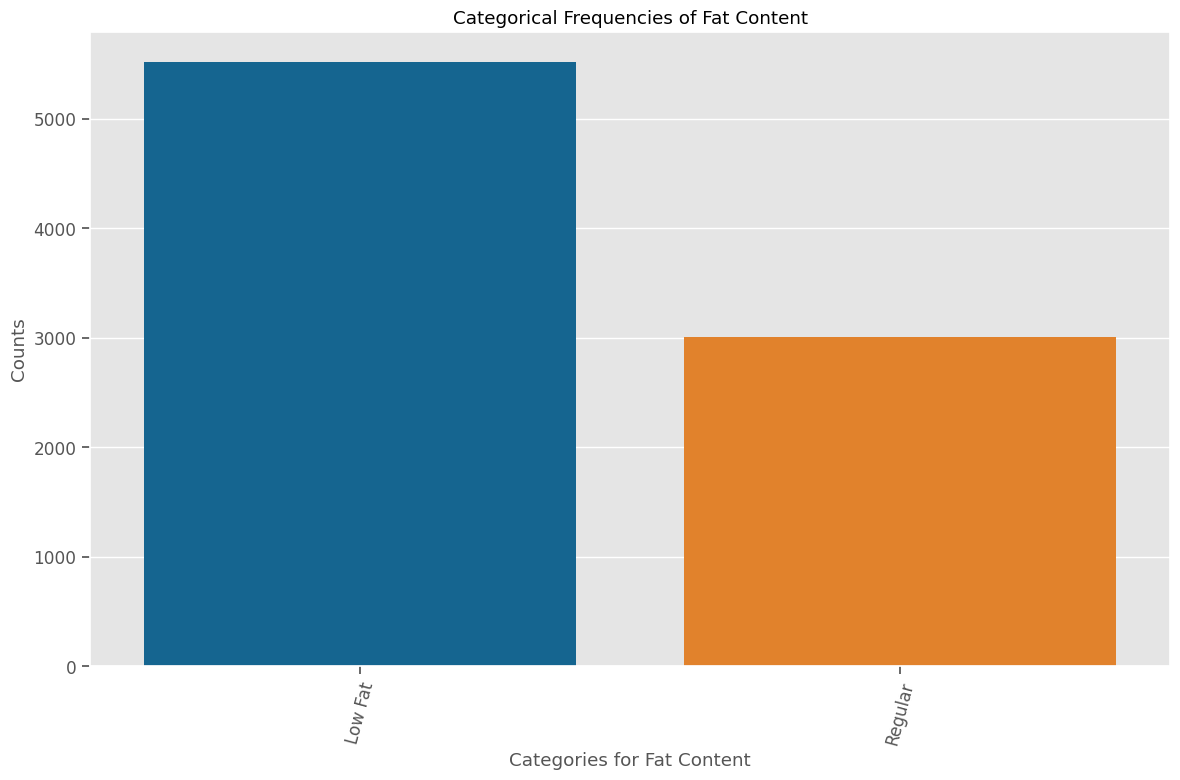

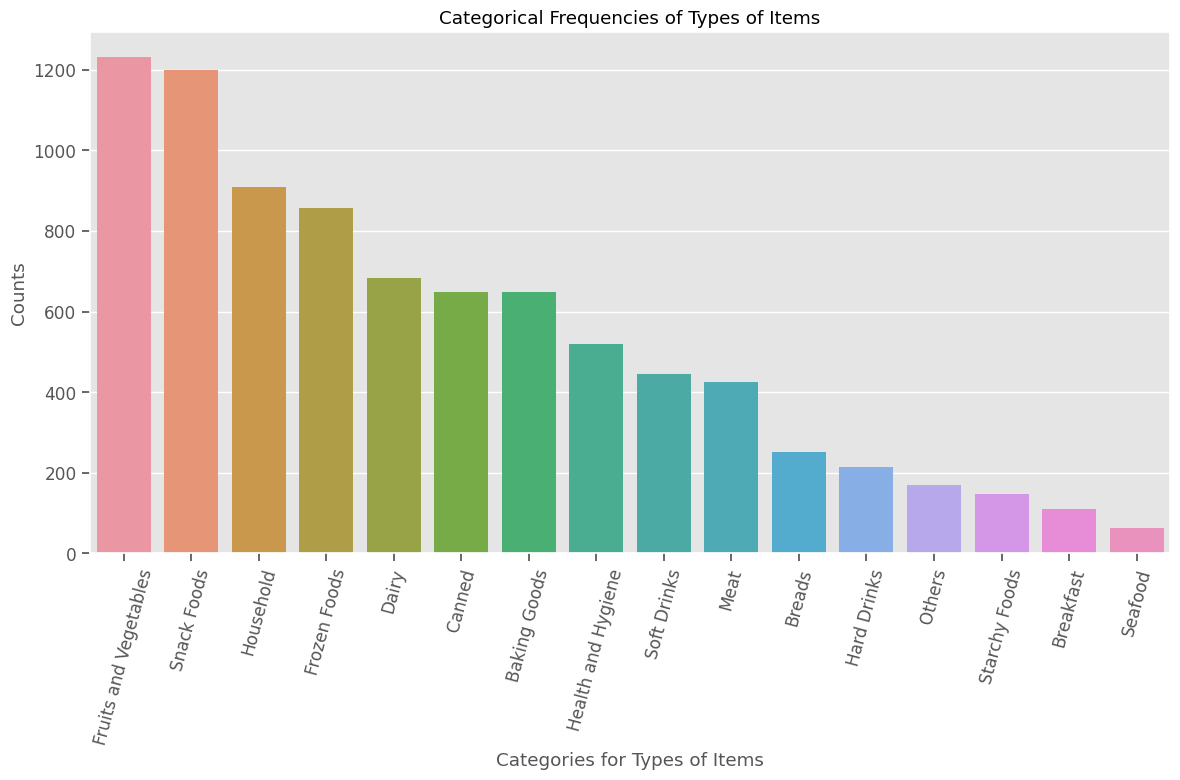

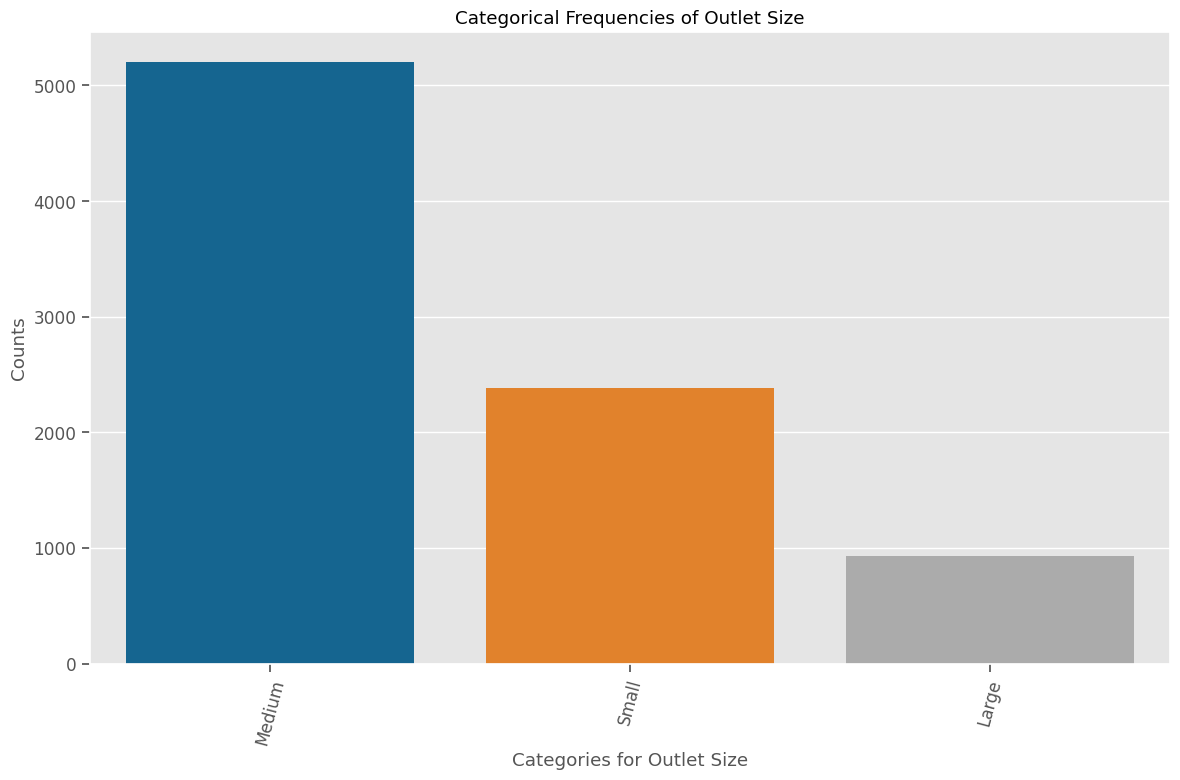

In [25]:
fig, ax = bar_plot(df, 'Item_Fat_Content', 'Fat Content');
fig, ax = bar_plot(df, 'Item_Type', 'Types of Items');
fig, ax = bar_plot(df, 'Outlet_Size', 'Outlet Size');

> Across all outlets there are 50% more low fat items

> We can see that across all outlets that the top 5 food types are fruits and vegetables, snack foods, household products, frozen foods, and dairy products

> There are more medium outlets than small and large outlets combined


C:\Users\hamma\AppData\Local\Temp\ipykernel_3388\1342623944.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True, cmap = 'Greens', linewidths = 1, linecolor = 'Black');


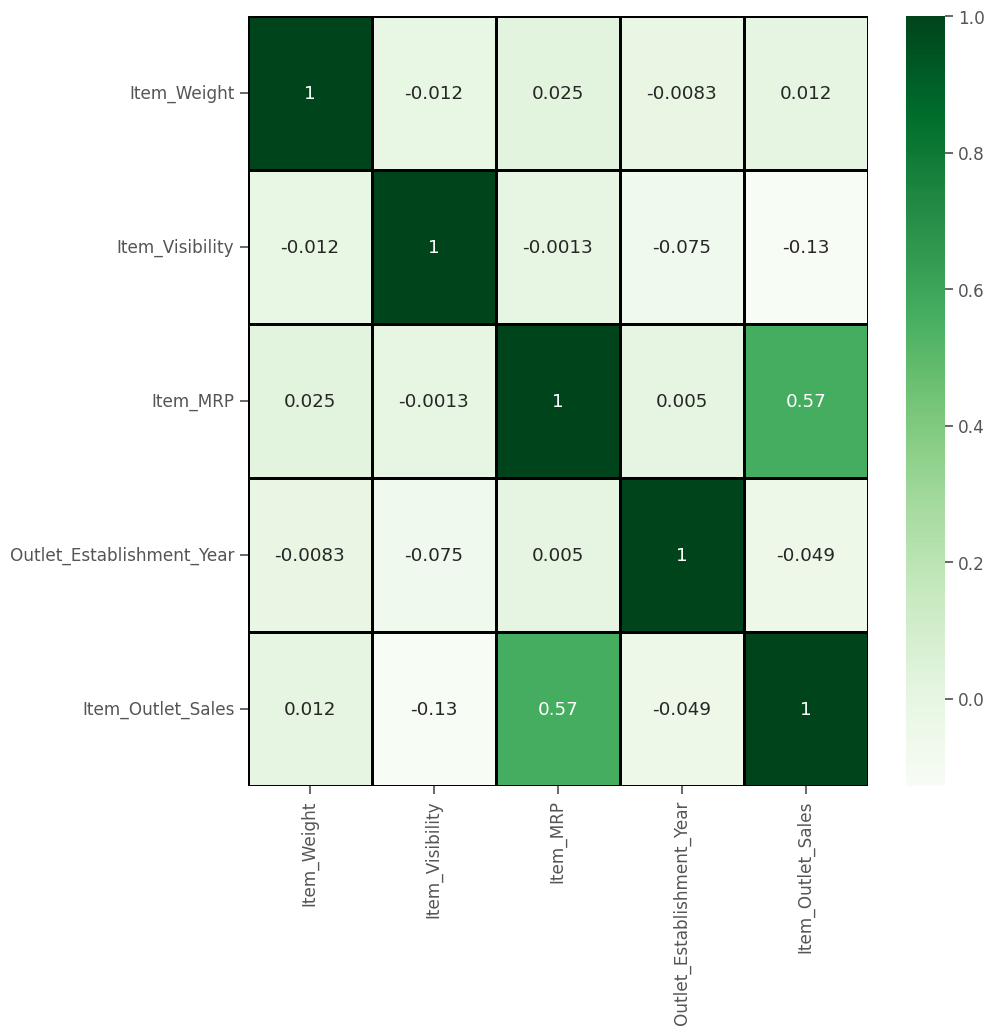

In [26]:
# Create heatmap to compare all features for correlation
# Adjust figure size
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(df.corr(), annot = True, cmap = 'Greens', linewidths = 1, linecolor = 'Black');

> There seems to only be two features that are moderately correlated, item sales and MRP

## Explanatory Visuals

In [27]:
# Get data frame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                8523 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Establishment_Year  8523 non-null   int64  
 6   Outlet_Size                8523 non-null   object 
 7   Outlet_Location_Type       8523 non-null   object 
 8   Outlet_Type                8523 non-null   object 
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 666.0+ KB


## 1. Do larger outlet sizes have more sales than smaller ones?

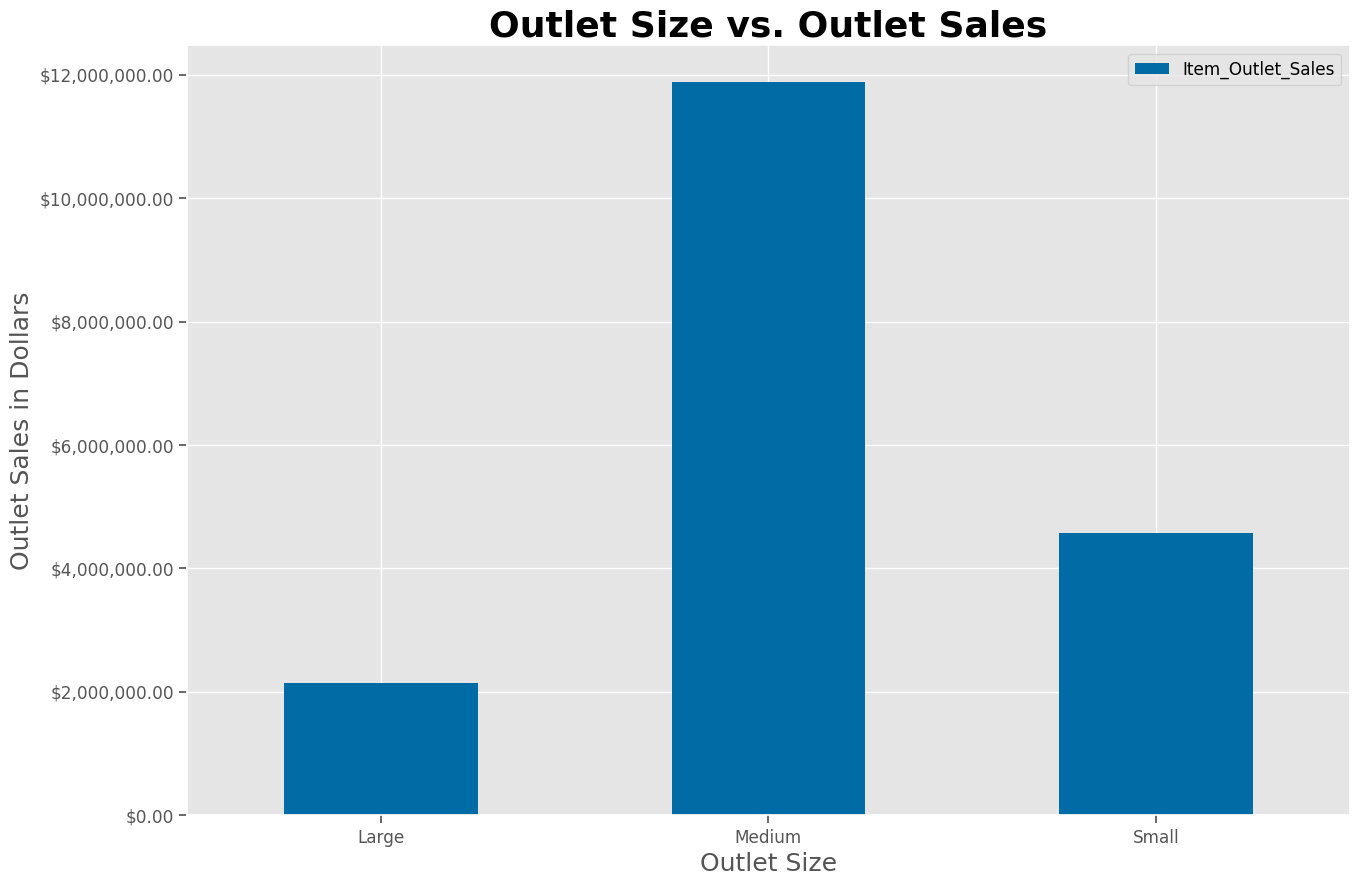

In [28]:
# Create barplot with outlet size as the x-axis and outlet sales as the y-axis
from matplotlib.ticker import FuncFormatter

# Group each outlet size and find the sum of the item sales
fig, sum_sales = plt.subplots(figsize = (15,10))
sum_sales = df.groupby('Outlet_Size')['Item_Outlet_Sales'].sum().plot.bar()
sum_sales.set_title('Outlet Size vs. Outlet Sales', fontsize = 26, fontweight = 'bold')
sum_sales.set_xlabel('Outlet Size', fontsize = 18)
sum_sales.set_ylabel('Outlet Sales in Dollars', fontsize = 18)
sum_sales.legend()
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation = 0)

# Turn ylabels into millions of dollars
def millions(x, pos):
  return f'${x:,.2f}'

price_millions = FuncFormatter(millions)
sum_sales.yaxis.set_major_formatter(price_millions)


> We can see that medium size outlets account for a majority of sales. Another question we would now need to answer is: What is the ratio of sales per number of high, medium, and small outlets?

2. Do more recently established stores sell more items?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


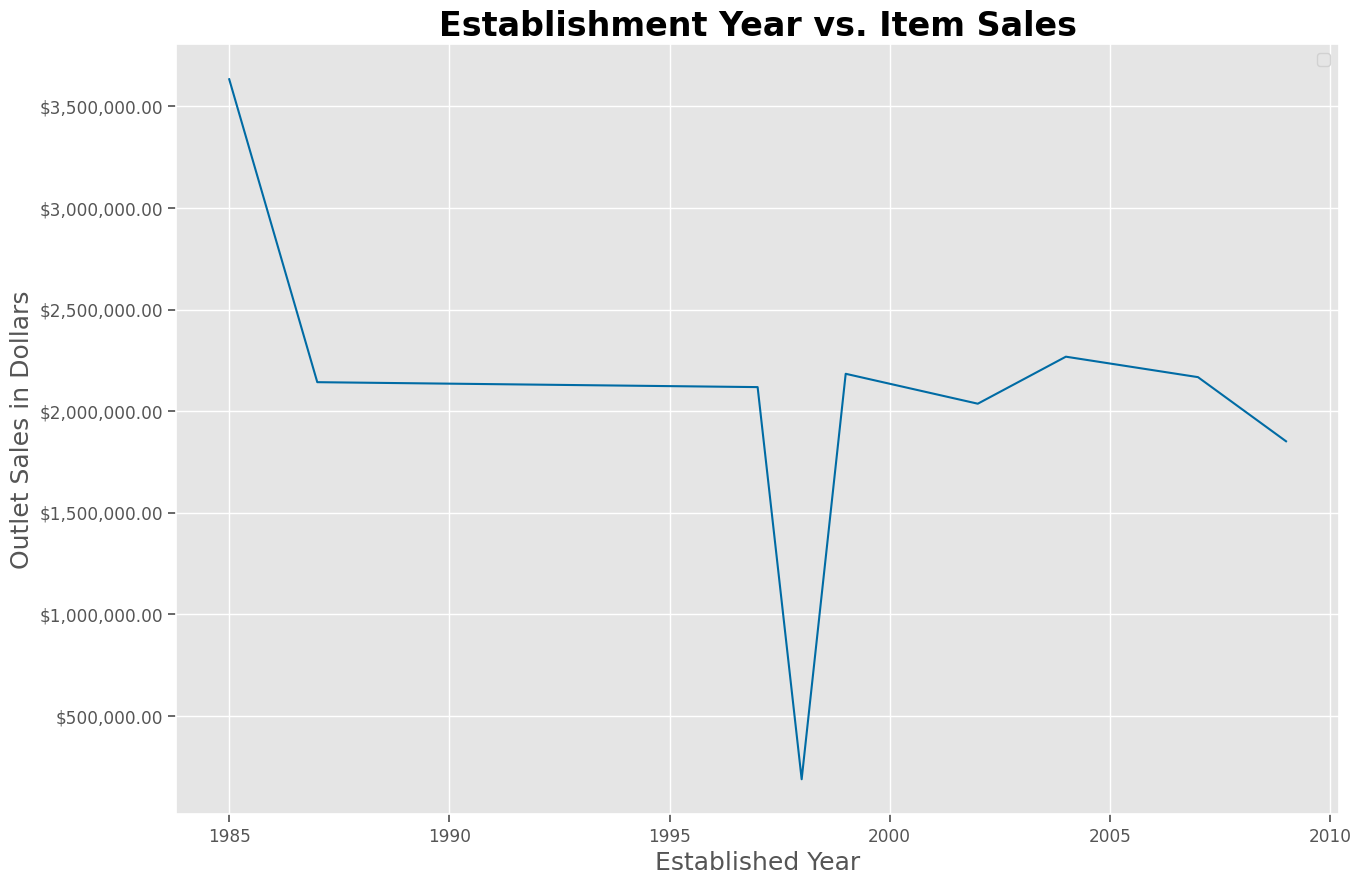

In [29]:
# Create lineplot to show the trend of Established Year vs. Sales
fig, ax = plt.subplots(figsize = (15, 10))

data = df.groupby('Outlet_Establishment_Year', as_index = False)['Item_Outlet_Sales'].sum()
ax = sns.lineplot(data = data, x = 'Outlet_Establishment_Year', y = 'Item_Outlet_Sales')
ax.set_title('Establishment Year vs. Item Sales', fontsize = 24, fontweight = 'bold')

ax.set_xlabel('Established Year', fontsize = 18)
ax.set_ylabel('Outlet Sales in Dollars', fontsize = 18)
ax.legend()
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation = 0)


# Turn ylabels into millions of dollars
def millions(x, pos):
  return f'${x:,.2f}'

price_millions = FuncFormatter(millions)
ax.yaxis.set_major_formatter(price_millions)


> This graph shows that stores that have been established more recenty earn less

# Machine Learning for Predictions

In [30]:
# Load uncleaned dataset to prevent data leakage
filename = ('\\Users\\hamma\\Documents\\GitHub\\Project-1-Linear-Regression-Project\\sales_predictions.csv')
df = pd.read_csv(filename)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

In [31]:
# Descriptive statistics
df.describe()

Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count  7060.000000      8523.000000  8523.000000                8523.000000   
mean     12.857645         0.066132   140.992782                1997.831867   
std       4.643456         0.051598    62.275067                   8.371760   
min       4.555000         0.000000    31.290000                1985.000000   
25%       8.773750         0.026989    93.826500                1987.000000   
50%      12.600000         0.053931   143.012800                1999.000000   
75%      16.850000         0.094585   185.643700                2004.000000   
max      21.350000         0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          3101.296400  
max         13086.964800

> The columns that have a potential effect on item sales are 'Item_Fat_Content', 'Item_Visibility', 'Item_Type', and 'Outlet_Size'
### Types of Data
- Numeric: 'Item_Visibility'
- Ordinal: 'Outlet_Size'
- Nominal: 'Item_Type' and 'Item_Fat_Content'

In [32]:
# Remove Uncessary Columns
df.drop(columns=['Item_Identifier','Outlet_Identifier'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                7060 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Establishment_Year  8523 non-null   int64  
 6   Outlet_Size                6113 non-null   object 
 7   Outlet_Location_Type       8523 non-null   object 
 8   Outlet_Type                8523 non-null   object 
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 666.0+ KB


In [33]:
# Remove any duplicated rows
df.drop_duplicates()

Item_Weight Item_Fat_Content  Item_Visibility              Item_Type  \
0           9.300          Low Fat         0.016047                  Dairy   
1           5.920          Regular         0.019278            Soft Drinks   
2          17.500          Low Fat         0.016760                   Meat   
3          19.200          Regular         0.000000  Fruits and Vegetables   
4           8.930          Low Fat         0.000000              Household   
...           ...              ...              ...                    ...   
8518        6.865          Low Fat         0.056783            Snack Foods   
8519        8.380          Regular         0.046982           Baking Goods   
8520       10.600          Low Fat         0.035186     Health and Hygiene   
8521        7.210          Regular         0.145221            Snack Foods   
8522       14.800          Low Fat         0.044878            Soft Drinks   

      Item_MRP  Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0     249.8092                       1999      Medium               Tier 1   
1      48.2692                       2009      Medium               Tier 3   
2     141.6180                       1999      Medium               Tier 1   
3     182.0950                       1998         NaN               Tier 3   
4      53.8614                       1987        High               Tier 3   
...        ...                        ...         ...                  ...   
8518  214.5218                       1987        High               Tier 3   
8519  108.1570                       2002         NaN               Tier 2   
8520   85.1224                       2004       Small               Tier 2   
8521  103.1332                       2009      Medium               Tier 3   
8522   75.4670                       1997       Small               Tier 1   

            Outlet_Type  Item_Outlet_Sales  
0     Supermarket Type1          3735.1380  
1     Supermarket Type2           443.4228  
2     Supermarket Type1          2097.2700  
3         Grocery Store           732.3800  
4     Supermarket Type1           994.7052  
...                 ...                ...  
8518  Supermarket Type1          2778.3834  
8519  Supermarket Type1           549.2850  
8520  Supermarket Type1          1193.1136  
8521  Supermarket Type2          1845.5976  
8522  Supermarket Type1           765.6700  

[8523 rows x 10 columns]

In [34]:
# Check to make sure duplicates were removed
df.duplicated().sum()

0

In [35]:
# Check categorical data for inconsistencies
print(df['Item_Fat_Content'].value_counts(),'\n')
print(df['Item_Type'].value_counts(),'\n')
df['Outlet_Size'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64 

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64 



Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

> In the 'Item_Fat_Content' column, Low Fat is written three different ways (Low Fat, low fat, LF). Regular is written two diffent ways (Regular, reg). These will be changed to be consistent as the data is prepared for OneHotEncoding

In [36]:
# Fix inconsistencies and prepare categorical data for OneHotEncoding
df['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'}, inplace=True);
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [37]:
# Replace High value with Large
df['Outlet_Size'].replace({'High':'Large'}, inplace=True)

In [38]:
# Replace categorical values with numeric values for ordinal encoding
df['Outlet_Size'].replace({'Small':0,'Medium':1,'Large':2})

0       1.0
1       1.0
2       1.0
3       NaN
4       2.0
       ... 
8518    2.0
8519    NaN
8520    0.0
8521    1.0
8522    0.0
Name: Outlet_Size, Length: 8523, dtype: float64

In [39]:
# Identify X features and y target
y = df['Item_Outlet_Sales']
X= df.drop(columns = 'Item_Outlet_Sales')

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

## Machine Learning Pipeline

In [40]:
# Instantiate column selectors
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

# Instantiate transformers
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
scaler = StandardScaler()

# Instantiate imputers
freq_imp = SimpleImputer(strategy='most_frequent')
mean_imp = SimpleImputer(strategy='mean')

# Instantiate pipelines
num_pipe = make_pipeline(mean_imp, scaler)
cat_pipe = make_pipeline(freq_imp, ohe)

# Instantiate column transformers
# Tuples
num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)

#ColumnTransformer
preprocessor = make_column_transformer(num_tuple, cat_tuple, 
                                       verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001BA9398A9D0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001BA9398A940>)],
                  verbose_feature_names_out=False)

In [41]:
# Transform data
# Fit on training data
preprocessor.fit(X_train)

# Make X_train, X_test dataframes
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_test.index)
display(X_train_df)

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
4776     0.817249        -0.712775  1.828109                   1.327849   
7510     0.556340        -1.291052  0.603369                   1.327849   
5828    -0.131512         1.813319  0.244541                   0.136187   
5327    -1.169219        -1.004931 -0.952591                   0.732018   
4810     1.528819        -0.965484 -0.336460                   0.493686   
...           ...              ...       ...                        ...   
5734    -0.832409         4.309657 -0.044657                   0.017021   
5191     0.639356         1.008625 -1.058907                   1.089517   
5390     1.113736        -0.920527  1.523027                   0.493686   
860      1.766009        -0.227755 -0.383777                   1.089517   
7270     0.817249        -0.958677 -0.738361                  -0.102145   

      Item_Fat_Content_Low Fat  Item_Fat_Content_Regular  \
4776                       1.0                       0.0   
7510                       0.0                       1.0   
5828                       0.0                       1.0   
5327                       1.0                       0.0   
4810                       1.0                       0.0   
...                        ...                       ...   
5734                       0.0                       1.0   
5191                       1.0                       0.0   
5390                       1.0                       0.0   
860                        1.0                       0.0   
7270                       1.0                       0.0   

      Item_Type_Baking Goods  Item_Type_Breads  Item_Type_Breakfast  \
4776                     0.0               0.0                  0.0   
7510                     0.0               0.0                  0.0   
5828                     0.0               0.0                  0.0   
5327                     1.0               0.0                  0.0   
4810                     0.0               0.0                  0.0   
...                      ...               ...                  ...   
5734                     0.0               0.0                  0.0   
5191                     0.0               0.0                  0.0   
5390                     0.0               0.0                  0.0   
860                      0.0               0.0                  0.0   
7270                     0.0               0.0                  0.0   

      Item_Type_Canned  ...  Outlet_Size_Large  Outlet_Size_Medium  \
4776               0.0  ...                0.0                 1.0   
7510               0.0  ...                0.0                 1.0   
5828               0.0  ...                0.0                 1.0   
5327               0.0  ...                0.0                 0.0   
4810               0.0  ...                0.0                 1.0   
...                ...  ...                ...                 ...   
5734               0.0  ...                0.0                 1.0   
5191               0.0  ...                0.0                 1.0   
5390               0.0  ...                0.0                 1.0   
860                0.0  ...                0.0                 1.0   
7270               0.0  ...                0.0                 0.0   

      Outlet_Size_Small  Outlet_Location_Type_Tier 1  \
4776                0.0                          0.0   
7510                0.0                          0.0   
5828                0.0                          1.0   
5327                1.0                          0.0   
4810                0.0                          0.0   
...                 ...                          ...   
5734                0.0                          0.0   
5191                0.0                          0.0   
5390                0.0                          0.0   
860                 0.0                          0.0   
7270                1.0                          1.0   

      Outlet_Loca

## Linear Regression Model

In [42]:
# Instantiate linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, 
                    X_test_df, y_test)

## Extracting and Visualizing Linear Regression Model Coefficients

In [43]:
coeffs = get_coefficients(lin_reg)
coeffs

Item_Weight                       -7.883816e+00
Item_Visibility                   -2.194246e+01
Item_MRP                           9.845541e+02
Outlet_Establishment_Year          3.178986e+02
Item_Fat_Content_Low Fat           8.915746e+13
Item_Fat_Content_Regular           8.915746e+13
Item_Type_Baking Goods             1.270112e+15
Item_Type_Breads                   1.270112e+15
Item_Type_Breakfast                1.270112e+15
Item_Type_Canned                   1.270112e+15
Item_Type_Dairy                    1.270112e+15
Item_Type_Frozen Foods             1.270112e+15
Item_Type_Fruits and Vegetables    1.270112e+15
Item_Type_Hard Drinks              1.270112e+15
Item_Type_Health and Hygiene       1.270112e+15
Item_Type_Household                1.270112e+15
Item_Type_Meat                     1.270112e+15
Item_Type_Others                   1.270112e+15
Item_Type_Seafood                  1.270112e+15
Item_Type_Snack Foods              1.270112e+15
Item_Type_Soft Drinks              1.270

In [44]:
##formatting to use 4 decimals
pd.set_option('display.float_format',lambda x: f"{x:,.4f}")
pd.set_option('display.max_rows', None)

In [45]:
coeffs.sort_values()

intercept                         -4,401,623,455,266,426.0000
Outlet_Size_Medium                -3,264,778,910,758,685.5000
Outlet_Size_Small                 -3,264,778,910,758,632.0000
Outlet_Size_Large                 -3,264,778,910,757,737.5000
Item_Visibility                                      -21.9425
Item_Weight                                           -7.8838
Outlet_Establishment_Year                            317.8986
Item_MRP                                             984.5541
Item_Fat_Content_Low Fat              89,157,462,037,984.2656
Item_Fat_Content_Regular              89,157,462,038,047.6719
Item_Type_Dairy                    1,270,111,713,299,939.7500
Item_Type_Soft Drinks              1,270,111,713,300,001.0000
Item_Type_Others                   1,270,111,713,300,040.7500
Item_Type_Frozen Foods             1,270,111,713,300,051.7500
Item_Type_Breads                   1,270,111,713,300,056.5000
Item_Type_Snack Foods              1,270,111,713,300,059.7500
Item_Typ

In [46]:
# Check string columns for number of unique values
df.select_dtypes('object').nunique()

Item_Fat_Content         2
Item_Type               16
Outlet_Size              3
Outlet_Location_Type     3
Outlet_Type              4
dtype: int64

In [47]:
# Recreate model preprocessor with drop='if_binary'
# Instantiate column selectors
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

# Instantiate transformers
ohe = OneHotEncoder(drop='first', sparse=False)
scaler = StandardScaler()

# Instantiate imputers
freq_imp = SimpleImputer(strategy='most_frequent')
mean_imp = SimpleImputer(strategy='mean')

# Instantiate pipelines
num_pipe = make_pipeline(mean_imp, scaler)
cat_pipe = make_pipeline(freq_imp, ohe)

# Instantiate column transformers
# Tuples
num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)

#ColumnTransformer
preprocessor = make_column_transformer(num_tuple, cat_tuple, 
                                       verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001BA93BBF820>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001BA93BBFB50>)],
                  verbose_feature_names_out=False)

In [48]:
# Refit on training data
preprocessor.fit(X_train)

# Make X_train, X_test dataframes
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_test.index)
display(X_train_df)

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
4776       0.8172          -0.7128    1.8281                     1.3278   
7510       0.5563          -1.2911    0.6034                     1.3278   
5828      -0.1315           1.8133    0.2445                     0.1362   
5327      -1.1692          -1.0049   -0.9526                     0.7320   
4810       1.5288          -0.9655   -0.3365                     0.4937   
4377       0.0000          -0.1145   -0.5082                    -1.5321   
2280       1.8846          -0.0742   -0.8596                     0.7320   
8198       0.0000          -0.0480    1.9430                    -1.5321   
7514       1.6118           1.8516    1.8000                     0.7320   
3463      -1.1194          -0.5337   -0.4168                     0.7320   
7851       0.2836           0.4657    0.0123                     0.1362   
4595      -1.6899           0.1593    1.9206                    -0.1021   
4766       1.0189          -0.7989    0.0633                     0.7320   
1541      -1.1514           0.2487    1.8616                     1.3278   
6162      -1.6507           1.7545   -0.2238                     0.0170   
322        0.4970          -0.3257   -1.2673                     1.0895   
2031      -1.2582           1.4939    0.4849                     0.7320   
3847       0.3429          -0.9571   -0.5183                     0.4937   
7301      -1.6294          -0.0046    0.6921                     0.7320   
6820       0.9714           1.1777   -0.2434                     0.7320   
7092       1.9795          -0.9106   -0.3370                     0.1362   
110        0.0938           0.2699    1.4459                    -0.1021   
8099       0.0000           1.4233    0.0888                    -1.5321   
4891      -0.6178           0.0786    1.9424                     0.7320   
1079       1.2086          -0.3591    0.4896                     1.0895   
8125       0.0000           0.1282    0.9160                    -1.5321   
7413       1.8016          -0.9140   -0.9441                     1.3278   
5344       0.0000           1.5490   -1.7010                    -1.5321   
2291       0.4496           0.2941    0.8065                    -0.1021   
1164      -1.1977           0.1545    1.2211                     0.7320   
2276       0.0000           0.2244   -0.6480                    -1.5321   
1450       0.0000          -1.2911    1.7734                    -1.5321   
3908      -1.3139           1.8378   -0.7548                    -0.1021   
5852       1.1493           0.6231    1.5543                     0.1362   
7580       0.0000          -0.8797    0.3631                    -1.5321   
4367       1.1375          -0.7056    0.4328                     0.7320   
6252      -1.8938          -0.3930    0.9074                    -1.2938   
5874      -1.7658          -0.6607    0.7161                     0.1362   
2954       1.0544          -1.0039   -1.0919                    -1.2938   
2531      -1.6661          -0.8033    0.1031                     0.4937   
3684       1.5051           0.6979   -1.3938                    -1.2938   
5274       0.5208           0.0198    1.8898                    -1.2938   
5180       0.0000           0.3431    0.5938                    -1.5321   
2908       1.2561           0.4670    0.8484                     0.7320   
1514       0.0000           1.4227    0.0878                    -1.5321   
7439       0.9121          -1.2911    0.2265                    -0.1021   
1451       1.2916          -1.0152    1.3333                     1.0895   
2020       1.2086          -0.9119   -0.2408                    -0.1021   
2753       0.0000           1.6293   -0.3572                    -1.5321   
6572      -0.2620          -1.1227   -0.4332                     1.0895   
4506       1.5288           0.3180   -1.4879                    -0.1021   
7340      -1.6424          -0.4377    0.1000                     0.1362   
838        0.0464          -1.2

In [49]:
# Instantiate linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, 
                    X_test_df, y_test)

In [50]:
coeffs = get_coefficients(lin_reg)
coeffs

Item_Weight                          -7.8838
Item_Visibility                     -21.6436
Item_MRP                            984.6431
Outlet_Establishment_Year           289.7511
Item_Fat_Content_Regular             61.9604
Item_Type_Breads                    -23.5724
Item_Type_Breakfast                  47.2362
Item_Type_Canned                     28.9272
Item_Type_Dairy                    -105.3113
Item_Type_Frozen Foods               -1.9870
Item_Type_Fruits and Vegetables      47.9127
Item_Type_Hard Drinks                18.2826
Item_Type_Health and Hygiene         27.4640
Item_Type_Household                   5.7680
Item_Type_Meat                       -9.8570
Item_Type_Others                    -28.2301
Item_Type_Seafood                   329.2346
Item_Type_Snack Foods               -19.4872
Item_Type_Soft Drinks               -38.8365
Item_Type_Starchy Foods              46.2313
Outlet_Size_Medium                 -861.4159
Outlet_Size_Small                  -798.7672
Outlet_Loc

In [51]:
# For loop to see unique categories
for col in cat_selector(X):
    print(f"For {col}:\n{X[col].unique()}\n")

For Item_Fat_Content:
['Low Fat' 'Regular']

For Item_Type:
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']

For Outlet_Size:
['Medium' nan 'Large' 'Small']

For Outlet_Location_Type:
['Tier 1' 'Tier 3' 'Tier 2']

For Outlet_Type:
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']



In [52]:
# List of categories to drop
drop_cats = ['Low Fat','Others','Large','Tier 3','Grocery Store']

In [53]:
# Recreate model preprocessor with drop=drop_cats
# Instantiate column selectors
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

# Instantiate transformers
ohe = OneHotEncoder(drop=drop_cats, sparse=False)
scaler = StandardScaler()

# Instantiate imputers
freq_imp = SimpleImputer(strategy='most_frequent')
mean_imp = SimpleImputer(strategy='mean')

# Instantiate pipelines
num_pipe = make_pipeline(mean_imp, scaler)
cat_pipe = make_pipeline(freq_imp, ohe)

# Instantiate column transformers
# Tuples
num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)

#ColumnTransformer
preprocessor = make_column_transformer(num_tuple, cat_tuple, 
                                       verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001BA93B8D4C0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop=['Low Fat',
                                                                      'Others',
                                                                      'Large',
                                                                      'Tier 3',
                                                                      'Grocery '
                                                                      'Store'],
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001BA93B8D400>)],
                  verbose_feature_names_out=False)

In [63]:
# Refit on training data
preprocessor.fit(X_train)

# Make X_train, X_test dataframes
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_test.index)
display(X_train_df.head())

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
4776       0.8172          -0.7128    1.8281                     1.3278   
7510       0.5563          -1.2911    0.6034                     1.3278   
5828      -0.1315           1.8133    0.2445                     0.1362   
5327      -1.1692          -1.0049   -0.9526                     0.7320   
4810       1.5288          -0.9655   -0.3365                     0.4937   

      Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  \
4776                    0.0000                  0.0000            0.0000   
7510                    1.0000                  0.0000            0.0000   
5828                    1.0000                  0.0000            0.0000   
5327                    0.0000                  1.0000            0.0000   
4810                    0.0000                  0.0000            0.0000   

      Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  ...  \
4776               0.0000            0.0000           0.0000  ...   
7510               0.0000            0.0000           0.0000  ...   
5828               0.0000            0.0000           0.0000  ...   
5327               0.0000            0.0000           0.0000  ...   
4810               0.0000            0.0000           0.0000  ...   

      Outlet_Size_Large  Outlet_Size_Medium  Outlet_Size_Small  \
4776             0.0000              1.0000             0.0000   
7510             0.0000              1.0000             0.0000   
5828             0.0000              1.0000             0.0000   
5327             0.0000              0.0000             1.0000   
4810             0.0000              1.0000             0.0000   

      Outlet_Location_Type_Tier 1  Outlet_Location_Type_Tier 2  \
4776                       0.0000                       0.0000   
7510                       0.0000                       0.0000   
5828                       1.0000                       0.0000   
5327                       0.0000                       1.0000   
4810                       0.0000                       1.0000   

      Outlet_Location_Type_Tier 3  Outlet_Type_Grocery Store  \
4776                       1.0000                     0.0000   
7510                       1.0000                     0.0000   
5828                       0.0000                     0.0000   
5327                       0.0000                     0.0000   
4810                       0.0000                     0.0000   

      Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  \
4776                         0.0000                         1.0000   
7510                         0.0000                         1.0000   
5828                         1.0000                         0.0000   
5327                         1.0000                         0.0000   
4810                         1.0000                         0.0000   

      Outlet_Type_Supermarket Type3  
4776                         0.0000  
7510                         0.0000  
5828                         0.0000  
5327                         0.0000  
4810                         0.0000  

[5 rows x 31 columns]

In [55]:
coeffs = get_coefficients(lin_reg)
coeffs

Item_Weight                          -7.8838
Item_Visibility                     -21.6436
Item_MRP                            984.6431
Outlet_Establishment_Year           289.7511
Item_Fat_Content_Regular             61.9604
Item_Type_Breads                    -23.5724
Item_Type_Breakfast                  47.2362
Item_Type_Canned                     28.9272
Item_Type_Dairy                    -105.3113
Item_Type_Frozen Foods               -1.9870
Item_Type_Fruits and Vegetables      47.9127
Item_Type_Hard Drinks                18.2826
Item_Type_Health and Hygiene         27.4640
Item_Type_Household                   5.7680
Item_Type_Meat                       -9.8570
Item_Type_Others                    -28.2301
Item_Type_Seafood                   329.2346
Item_Type_Snack Foods               -19.4872
Item_Type_Soft Drinks               -38.8365
Item_Type_Starchy Foods              46.2313
Outlet_Size_Medium                 -861.4159
Outlet_Size_Small                  -798.7672
Outlet_Loc

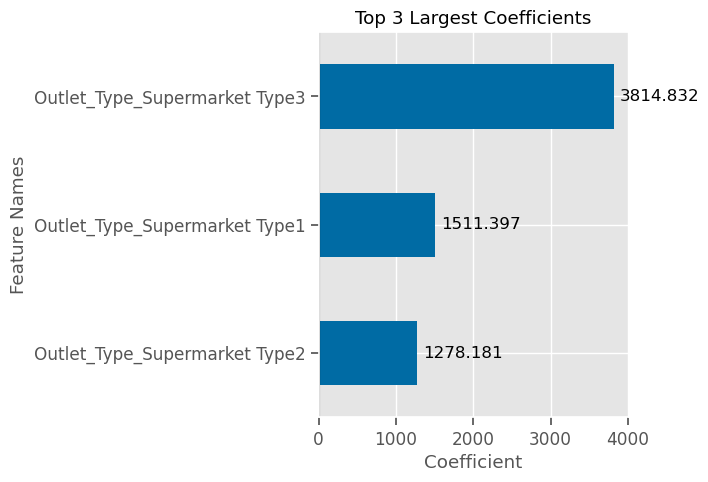

In [56]:
# Using function to plot 3 most important features and coefficients without
# intercept
ax= plot_coeffs(coeffs,top_n=3)
annotate_hbars(ax)
plt.savefig('lin_reg_coeff.png')

> The most important features the model used for predictions were the 3 Outlet_Type_Supermarket. If a store is Outlet_Type_Supermarket Type 3 sales will increase by \\$3,814.83.If a store is Outlet_Type_Supermarket Type 1 sales will increase by \\$1,511.40. If a store is Outlet_Type_Supermarket Type 2 sales will increase by \\$1,278.18.

## Regression Tree Model

In [57]:
# Recreate model preprocessor with drop='if_binary'
# Instantiate column selectors
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

# Instantiate transformers
ohe = OneHotEncoder(drop='if_binary', sparse=False)
scaler = StandardScaler()

# Instantiate imputers
freq_imp = SimpleImputer(strategy='most_frequent')
mean_imp = SimpleImputer(strategy='mean')

# Instantiate pipelines
num_pipe = make_pipeline(mean_imp, scaler)
cat_pipe = make_pipeline(freq_imp, ohe)

# Instantiate column transformers
# Tuples
num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)

#ColumnTransformer
preprocessor = make_column_transformer(num_tuple, cat_tuple, 
                                       verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001BA98669FA0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001BA98669550>)],
                  verbose_feature_names_out=False)

In [58]:
# fit and get feature names
preprocessor.fit(X_train)

feature_names=preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                         columns=feature_names, index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                        columns=feature_names, index=X_test.index)
X_test_df.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
7503       0.3310          -0.7766   -0.9988                    -1.2938   
2957      -1.1799           0.1003   -1.5852                    -0.1021   
7031       0.3784          -0.4830   -1.5958                     0.1362   
1084       0.0000          -0.4154    0.5066                    -1.5321   
856       -0.6427          -1.0474    0.8867                     0.7320   

      Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  \
7503                    0.0000                  0.0000            0.0000   
2957                    0.0000                  0.0000            0.0000   
7031                    1.0000                  0.0000            0.0000   
1084                    1.0000                  0.0000            0.0000   
856                     1.0000                  0.0000            0.0000   

      Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  ...  \
7503               0.0000            0.0000           0.0000  ...   
2957               0.0000            0.0000           0.0000  ...   
7031               0.0000            1.0000           0.0000  ...   
1084               0.0000            0.0000           0.0000  ...   
856                0.0000            0.0000           0.0000  ...   

      Outlet_Size_Large  Outlet_Size_Medium  Outlet_Size_Small  \
7503             1.0000              0.0000             0.0000   
2957             0.0000              0.0000             1.0000   
7031             0.0000              1.0000             0.0000   
1084             0.0000              1.0000             0.0000   
856              0.0000              0.0000             1.0000   

      Outlet_Location_Type_Tier 1  Outlet_Location_Type_Tier 2  \
7503                       0.0000                       0.0000   
2957                       1.0000                       0.0000   
7031                       1.0000                       0.0000   
1084                       0.0000                       0.0000   
856                        0.0000                       1.0000   

      Outlet_Location_Type_Tier 3  Outlet_Type_Grocery Store  \
7503                       1.0000                     0.0000   
2957                       0.0000                     0.0000   
7031                       0.0000                     0.0000   
1084                       1.0000                     0.0000   
856                        0.0000                     0.0000   

      Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  \
7503                         1.0000                         0.0000   
2957                         1.0000                         0.0000   
7031                         1.0000                         0.0000   
1084                         0.0000                         0.0000   
856                          1.0000                         0.0000   

      Outlet_Type_Supermarket Type3  
7503                         0.0000  
2957                         0.0000  
7031                         0.0000  
1084                         1.0000  
856                          0.0000  

[5 rows x 31 columns]

In [59]:
# Create Model instance
dec_tree = DecisionTreeRegressor()
dec_tree.fit(X_train_df,y_train)
evaluate_regression(dec_tree, X_train_df, y_train, X_test_df, y_test)

In [60]:
feature_importance = pd.Series(dec_tree.feature_importances_, index=feature_names,
                        name='Decision Tree Feature Importances')
feature_importance.head()

Item_Weight                 0.0368
Item_Visibility             0.1127
Item_MRP                    0.4557
Outlet_Establishment_Year   0.0365
Item_Fat_Content_Regular    0.0067
Name: Decision Tree Feature Importances, dtype: float64

> The R2 for the training set is 1, while the testing set R2 is 0.19. This suggests the model has high bias.

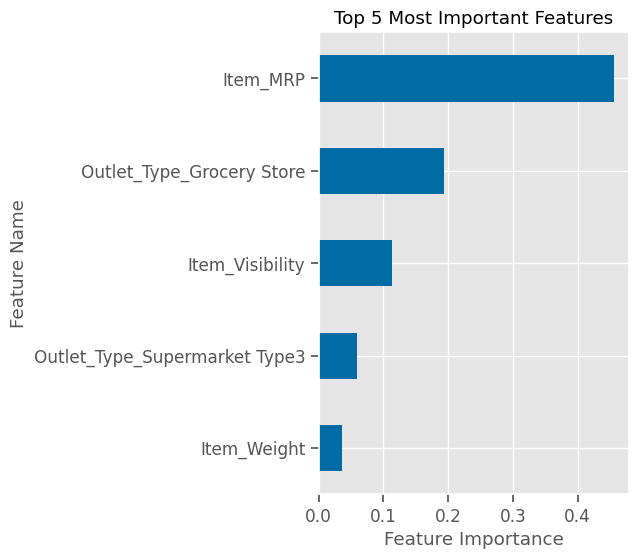

In [61]:
# Visualize top 5 most important features
ax = feature_importance.sort_values().tail(5).plot(kind='barh',figsize=(4,6))
ax.set(ylabel='Feature Name',xlabel='Feature Importance',
       title='Top 5 Most Important Features');
plt.savefig('dec_tree_features.png')

## Serialization of Models

In [62]:
# Linear Regression
## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df,
          "y_test": y_test,
         'preprocessor':preprocessor,
         'LinearRegression':lin_reg,
         'DecisionTreeRegressor':dec_tree}
joblib.dump(export, 'project_1_best_models.joblib')

['project_1_best_models.joblib']

## Model Recommendation:
- The model I recommend using is the linear regression model. The testing model performed better than the decision tree and the training and testing set of the linear regression model performed similarly suggesting that there is low bias.